In [ ]:
! pip install imutils

In [30]:
import numpy as np 

import os
from os import listdir
import gc
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt




from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,BatchNormalization,Flatten,Dense,MaxPooling2D,Dropout
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils import shuffle #shuffling the data improves the model

from sklearn.metrics import classification_report, f1_score, recall_score, precision_score ,accuracy_score
import imutils




In [2]:
image_dir="brain_tumor_dataset/"

In [6]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                    width_shift_range=0.1, 
                                    height_shift_range=0.1, 
                                    shear_range=0.1, 
                                    brightness_range=(0.3, 1.0),
                                    horizontal_flip=True, 
                                    vertical_flip=True, 
                                    fill_mode='nearest'
                                    )

    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [3]:
#os.makedirs('augmented-images')
#os.makedirs('augmented-images/yes')
#os.makedirs('augmented-images/no')
augmented_data_path ='augmented-images/'

In [ ]:

# augment data for the examples with label equal to 'yes' representing tumurous examples
augment_data(file_dir=image_dir+'yes',n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
# augment data for the examples with label equal to 'no' representing non-tumurous examples
augment_data(file_dir=image_dir+'no', n_generated_samples=9, save_to_dir=augmented_data_path+'no')

In [4]:
def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

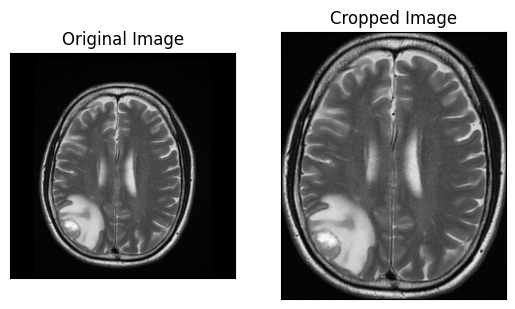

In [5]:
ex_img = cv2.imread(image_dir+'yes/Y107.jpg')
ex_crop_img = crop_brain_contour(ex_img, True)

Loading Data

In [6]:
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [7]:
augmented_yes =augmented_data_path+'yes'
augmented_no = augmented_data_path+'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


In [7]:
def plot_sample_images(X, y, n=40):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

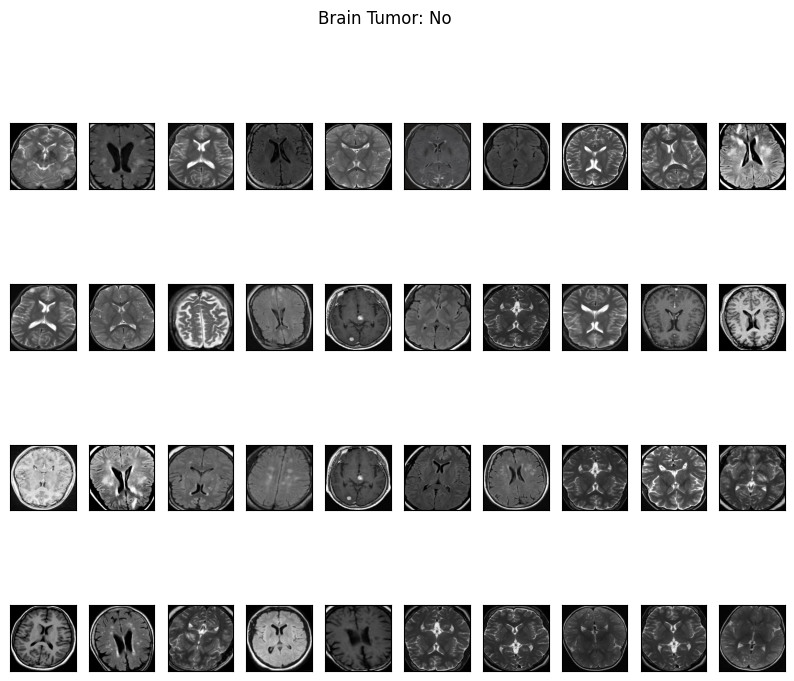

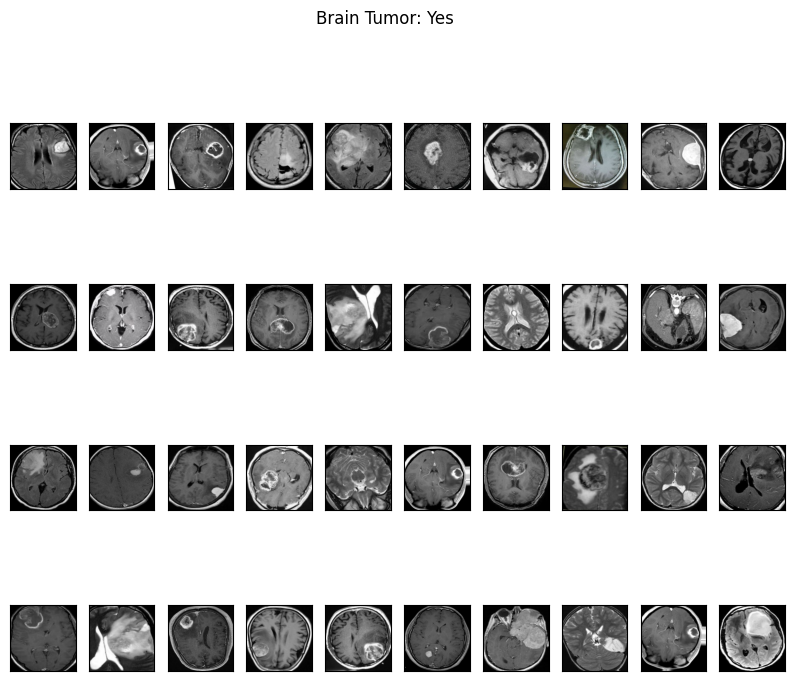

In [8]:
plot_sample_images(X, y)

In [8]:
gc.collect()

6082

Train Test Split data to Train Val Test Data 

In [9]:
def split_data(X, y, test_size=0.2):
       
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [10]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [11]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 1445
number of validation examples = 310
number of test examples = 310


Building CNN Model

In [14]:
def cnn_model(input_shape, activation = 'relu'):
    
    inputs = Input(shape= input_shape)
    
    conv0 = Conv2D(32, 3, activation = activation, padding = 'same')(inputs)
    max0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    batch0= BatchNormalization(axis=3, name='bn0')(max0)
    
    conv1 = Conv2D(32, 3, activation = activation, padding = 'same')(batch0)
    max1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    batch1= BatchNormalization(axis=3, name='bn1')(max1)
    
    conv2 = Conv2D(64, 3, activation = activation, padding = 'same')(batch1)
    max2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    batch2= BatchNormalization(axis=3, name='bn2')(max2)
    
    conv3 = Conv2D(128, 3, activation = activation, padding = 'same')(batch2)
    max3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    batch3= BatchNormalization(axis=3, name='bn3')(max3)
    
    conv4 = Conv2D(256, 3, activation = activation, padding = 'same')(batch3)
    max3 = MaxPooling2D(pool_size=(2, 2))(conv4)
    batch4= BatchNormalization(axis=3, name='bn4')(max3)
    
    conv5 = Conv2D(512, 3, activation = activation, padding = 'same')(batch4)
    max4 = MaxPooling2D(pool_size=(2, 2))(conv5)
    batch5= BatchNormalization(axis=3, name='bn5')(max4)
    
    flat1 = Flatten()(batch5)
    
    dens1 = Dense(256, activation=activation)(flat1)
    batch7= BatchNormalization(name='bn7')(dens1)
    drop2 = tf.keras.layers.Dropout(0.2)(batch7)
    
    
    dens2 = Dense(128, activation=activation)(drop2)
    batch8= BatchNormalization(name='bn8')(dens2)
    
    
    out = Dense(1, activation='sigmoid')(batch8)
    
    model = Model(inputs=inputs, outputs=out)
    
    return model
    
    
    

In [15]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model=cnn_model(IMG_SHAPE, activation= 'LeakyReLU')
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 240, 240, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 120, 120, 32)     0         
 2D)                                                             
                                                                 
 bn0 (BatchNormalization)    (None, 120, 120, 32)      128       
                                                                 
 conv2d_7 (Conv2D)           (None, 120, 120, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 60, 60, 32)       0         
 2D)                                                       

In [16]:
gc.collect()

1872

Call Backs for Saving the best model and checking Learning Rate

In [17]:
checkpoint_filepath = 'best_model2.h5'


checkpoint_loss = ModelCheckpoint(
    'best_loss_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)


checkpoint_acc = ModelCheckpoint(
    'best_accuracy_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr1 = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1)


In [18]:
model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:

model.fit(x=X_train, y=y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val),
                callbacks=[checkpoint_loss, checkpoint_acc, reduce_lr1])

Epoch 1/50
46/46 [==============================] - ETA: 0s - loss: 0.5148 - accuracy: 0.7716
Epoch 1: val_loss improved from inf to 0.68968, saving model to best_loss_model.h5

Epoch 1: val_accuracy improved from -inf to 0.54194, saving model to best_accuracy_model.h5
46/46 [==============================] - 18s 203ms/step - loss: 0.5148 - accuracy: 0.7716 - val_loss: 0.6897 - val_accuracy: 0.5419 - lr: 0.0010
Epoch 2/50
45/46 [============================>.] - ETA: 0s - loss: 0.2446 - accuracy: 0.9021
Epoch 2: val_loss did not improve from 0.68968

Epoch 2: val_accuracy did not improve from 0.54194
46/46 [==============================] - 8s 172ms/step - loss: 0.2441 - accuracy: 0.9024 - val_loss: 1.1867 - val_accuracy: 0.5355 - lr: 0.0010
Epoch 3/50
45/46 [============================>.] - ETA: 0s - loss: 0.1847 - accuracy: 0.9312
Epoch 3: val_loss did not improve from 0.68968

Epoch 3: val_accuracy improved from 0.54194 to 0.58065, saving model to best_accuracy_model.h5
46/46 [====

In [20]:
history = model.history.history

Ploting

In [22]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

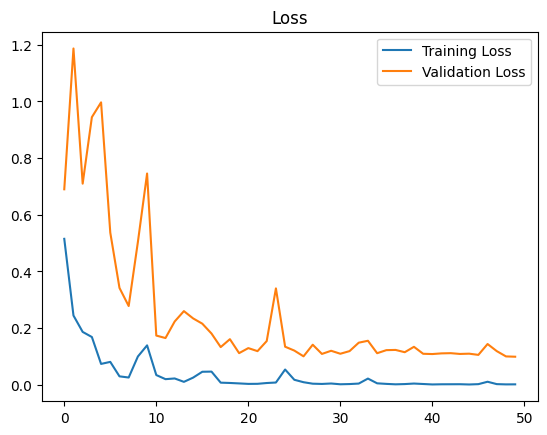

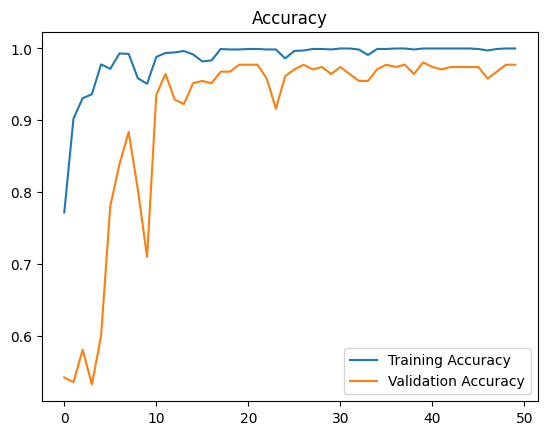

In [23]:
plot_metrics(history)

In [24]:
loss, accuracy = model.evaluate(X_test, y_test)

# Print the accuracy
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test loss: {loss * 100:.2f}%")

10/10 [==============================] - 1s 55ms/step - loss: 0.0184 - accuracy: 0.9903
Test Accuracy: 99.03%
Test loss: 1.84%


In [25]:
best_model1 = load_model('best_loss_model.h5')
predictions = best_model1.evaluate(X_test, y_test)

10/10 [==============================] - 1s 54ms/step - loss: 0.0184 - accuracy: 0.9903


In [26]:
best_model2 = load_model('best_accuracy_model.h5')
predictions = best_model2.evaluate(X_test, y_test)

10/10 [==============================] - 1s 54ms/step - loss: 0.0242 - accuracy: 0.9839


In [ ]:
precision_score

In [31]:
pred = model.predict(X_test)

predicted_classes = (pred > 0.5).astype("int32")


accuracy = accuracy_score(y_test, predicted_classes)
print(f"Accuracy: {accuracy:.2f}")


recall = recall_score(y_test, predicted_classes)
print(f"Recall: {recall:.2f}")

recall = precision_score(y_test, predicted_classes)
print(f"Recall: {recall:.2f}")


f1 = f1_score(y_test, predicted_classes)
print(f"F1-Score: {f1:.2f}")
print('-------------------------------')

report = classification_report(y_test, predicted_classes)
print("Classification Report:")
print(report)

10/10 [==============================] - 1s 81ms/step
Accuracy: 0.99
Recall: 0.99
Recall: 0.99
F1-Score: 0.99
-------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       140
           1       0.99      0.99      0.99       170

    accuracy                           0.99       310
   macro avg       0.99      0.99      0.99       310
weighted avg       0.99      0.99      0.99       310

